In [1]:
from model import BertForConstrainClustering
from utils import *
import argparse
import random
import torch
import os
import pandas as pd
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear
from pytorch_pretrained_bert.modeling import WEIGHTS_NAME, CONFIG_NAME
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from datetime import datetime
import warnings
warnings.warn = warn

results_all = {}
seed = 44
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

task_name = dataset = 'snips'
fraction = 1
labeled_ratio = 0.1
unknown_cls_ratio = 0.25

data_dir = 'data/' + task_name
output_dir = '/tmp/' + datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
bert_model = "/data/disk1/sharing/pretrained_embedding/bert/uncased_L-12_H-768_A-12"
num_train_epochs = 46

max_seq_task = {
    "snips": 35,
    'dbpedia': 54,
    "stackoverflow": 20,
}
max_seq_length = max_seq_task[task_name]
train_batch_size = 256
eval_batch_size = 256
learning_rate = 2e-5
warmup_proportion = 0.1

processors = {
    "snips": SnipsProcessor,
    'dbpedia': Dbpedia_Processor,
    "stackoverflow": Stackoverflow_Processor,
}

num_labels_task = {
    "snips": 7,
    'dbpedia': 14,
    "stackoverflow": 20,
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
logger.info("device: {} n_gpu: {}".format(device, n_gpu))
logger.disabled = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if os.path.exists(output_dir) and os.listdir(output_dir):
    raise ValueError("Output directory ({}) already exists and is not empty.".format(output_dir))
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if task_name not in processors:
    raise ValueError("Task not found: %s" % (task_name))

processor = processors[task_name]()
num_labels = num_labels_task[task_name]
label_list = processor.get_labels()
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)

# Freezing all transformer (except the last layer)
model = BertForConstrainClustering.from_pretrained(bert_model, num_labels = num_labels*fraction)
for name, param in model.bert.named_parameters():  
    param.requires_grad = False
    if "encoder.layer.11" in name or "pooler" in name:
        param.requires_grad = True
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

train_examples = processor.get_train_examples(data_dir)
num_train_optimization_steps = int(len(train_examples) / train_batch_size) * num_train_epochs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=learning_rate,
                     warmup=warmup_proportion,
                     t_total=num_train_optimization_steps)

## Settings of unknown classes discovery
# 1. Select 25% classes as unknown(-1)
# 2. Set 90% of examples as unknown(-1)
n_unknown_cls = round(num_labels*unknown_cls_ratio)
label_unknown = np.random.choice(np.array(label_list), n_unknown_cls, replace=False)

train_labeled_examples, train_unlabeled_examples = [], []
for example in train_examples:
    if (example.label not in label_unknown) and (np.random.uniform(0, 1) <= labeled_ratio):
        train_labeled_examples.append(example)
    else:
        train_unlabeled_examples.append(example)


train_loss = 0
train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer)
logger.info("***** Loading training set *****")
logger.info("  Num examples = %d", len(train_examples))
train_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
train_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
train_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
train_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
train_data = TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label_ids)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)


train_labeled_features = convert_examples_to_features(train_labeled_examples, label_list, max_seq_length, tokenizer)
logger.info("***** Running training(labeled) *****")
logger.info("  Num examples = %d", len(train_labeled_features))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_optimization_steps)
train_labeled_input_ids = torch.tensor([f.input_ids for f in train_labeled_features], dtype=torch.long)
train_labeled_input_mask = torch.tensor([f.input_mask for f in train_labeled_features], dtype=torch.long)
train_labeled_segment_ids = torch.tensor([f.segment_ids for f in train_labeled_features], dtype=torch.long)
train_labeled_label_ids = torch.tensor([f.label_id for f in train_labeled_features], dtype=torch.long)

train_labeled_data = TensorDataset(train_labeled_input_ids, train_labeled_input_mask, train_labeled_segment_ids, train_labeled_label_ids)
train_labeled_sampler = RandomSampler(train_labeled_data)
train_labeled_dataloader = DataLoader(train_labeled_data, sampler=train_labeled_sampler, batch_size=train_batch_size)


train_unlabeled_features = convert_examples_to_features(train_unlabeled_examples, label_list, max_seq_length, tokenizer)
logger.info("***** Running training(unlabeled) *****")
logger.info("  Num examples = %d", len(train_unlabeled_features))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_optimization_steps)
train_unlabeled_input_ids = torch.tensor([f.input_ids for f in train_unlabeled_features], dtype=torch.long)
train_unlabeled_input_mask = torch.tensor([f.input_mask for f in train_unlabeled_features], dtype=torch.long)
train_unlabeled_segment_ids = torch.tensor([f.segment_ids for f in train_unlabeled_features], dtype=torch.long)
train_unlabeled_label_ids = torch.tensor([-1 for f in train_unlabeled_features], dtype=torch.long)
train_semi_input_ids = torch.cat([train_labeled_input_ids, train_unlabeled_input_ids])
train_semi_input_mask = torch.cat([train_labeled_input_mask, train_unlabeled_input_mask])
train_semi_segment_ids = torch.cat([train_labeled_segment_ids, train_unlabeled_segment_ids])
train_semi_label_ids = torch.cat([train_labeled_label_ids, train_unlabeled_label_ids])

train_semi_data = TensorDataset(train_semi_input_ids, train_semi_input_mask, train_semi_segment_ids, train_semi_label_ids)
train_semi_sampler = RandomSampler(train_semi_data)
train_semi_dataloader = DataLoader(train_semi_data, sampler=train_semi_sampler, batch_size=train_batch_size)

12/25/2019 17:48:15 - INFO - utils -   device: cuda n_gpu: 1
12/25/2019 17:48:15 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file /data/disk1/sharing/pretrained_embedding/bert/uncased_L-12_H-768_A-12/vocab.txt
12/25/2019 17:48:15 - INFO - pytorch_pretrained_bert.modeling -   loading archive file /data/disk1/sharing/pretrained_embedding/bert/uncased_L-12_H-768_A-12
12/25/2019 17:48:15 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

12/25/2019 17:48:18 - INFO - pytorch_pretrained_bert.modeling -   Weights of BertForConstrainClustering not initialized from pretrained model: ['cluster_layer', 'dense.weight', 'dense.bias', 'classifier.weight', 'cl

Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/46 [00:36<27:14, 36.33s/it]

[[24  4  7 17  4  0 44]
 [ 0 99  0  0  0  1  0]
 [ 0  0  0  0  0  0  0]
 [ 7  2 17 74  0  0  0]
 [12 20 13  5 40  3  7]
 [ 0  0  0  0  0  0  0]
 [ 5  4 21  5  1  2 62]]
0: loss=0.583169705592669, (u, l) = (0.95,0.455)


Epoch:   4%|▍         | 2/46 [01:25<29:22, 40.07s/it]

[[26  5 10  5  4  2 48]
 [ 0 99  0  0  0  1  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0 11 87  0  1  0]
 [15 10 24  1 43  4  3]
 [ 0  0  0  0  0  0  0]
 [ 4  1 26  0  0  2 67]]
1: loss=0.5705461066502792, (u, l) = (0.9401,0.456)


Epoch:   7%|▋         | 3/46 [02:15<30:55, 43.15s/it]

[[35  1  3  4  5  3 49]
 [ 0 99  0  0  0  1  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0 95  3  1  0]
 [16  7 34  3 35  4  1]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0 17  2 80]]
2: loss=0.5447999238967896, (u, l) = (0.9302,0.457)


Epoch:   9%|▊         | 4/46 [03:06<31:53, 45.56s/it]

[[ 30   2   2   7   3   6  50]
 [  0 100   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0  98   0   2   0]
 [ 11   5  34   1  45   4   0]
 [  0   0   0   0   0   0   0]
 [  0   0   3   0   0   1  96]]
3: loss=0.5177683778680288, (u, l) = (0.9203,0.458)


Epoch:  11%|█         | 5/46 [03:58<32:21, 47.35s/it]

[[36  1  0 13  0  6 44]
 [ 0 99  0  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 98  0  2  0]
 [15  3 30  1 49  2  0]
 [ 0  0  0  0  0  0  0]
 [ 2  0  0  0  1  0 97]]
4: loss=0.494927616073535, (u, l) = (0.9104,0.459)


Epoch:  13%|█▎        | 6/46 [04:50<32:29, 48.74s/it]

[[25  1  0 21  0 11 42]
 [ 0 99  0  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 8  4 28  1 56  3  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 99]]
5: loss=0.4764009095155276, (u, l) = (0.9005,0.46)


Epoch:  15%|█▌        | 7/46 [05:43<32:30, 50.02s/it]

[[37  1  0 15  0  4 43]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 6  3 33  1 55  2  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 99]]
6: loss=0.46056690124365, (u, l) = (0.8906,0.4609)


Epoch:  17%|█▋        | 8/46 [06:36<32:13, 50.89s/it]

[[43  1  0 12  0  4 40]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [11  2 24  1 60  2  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 99]]
7: loss=0.447547598527028, (u, l) = (0.8807,0.4619)


Epoch:  20%|█▉        | 9/46 [07:30<31:57, 51.83s/it]

[[ 35   1   0  11   0   3  50]
 [  0  98   1   0   1   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0  99   0   1   0]
 [ 10   2  24   1  61   2   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 100]]
8: loss=0.4358903616666794, (u, l) = (0.8708,0.4629)


Epoch:  22%|██▏       | 10/46 [08:23<31:24, 52.34s/it]

[[44  1  0 14  0  4 37]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 8  2 23  1 64  2  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
9: loss=0.4218651858659891, (u, l) = (0.8609,0.4639)


Epoch:  24%|██▍       | 11/46 [09:16<30:42, 52.63s/it]

[[39  0  0 11  0  8 42]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 7  2 19  1 69  2  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
10: loss=0.4089169674194776, (u, l) = (0.851,0.4649)


Epoch:  26%|██▌       | 12/46 [10:10<29:57, 52.85s/it]

[[42  0  0 10  0  8 40]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [11  2 16  1 68  2  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
11: loss=0.3965758841771346, (u, l) = (0.8411,0.4659)


Epoch:  28%|██▊       | 13/46 [11:04<29:15, 53.19s/it]

[[ 40   0   0   8   0  11  41]
 [  0  98   0   0   1   1   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0  99   0   1   0]
 [  9   2  18   1  68   2   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 100]]
12: loss=0.385424493597104, (u, l) = (0.8312,0.4669)


Epoch:  30%|███       | 14/46 [11:56<28:14, 52.97s/it]

[[ 39   0   0  10   0  11  40]
 [  0  98   0   0   1   1   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0  99   0   1   0]
 [ 10   1  18   1  68   2   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 100]]
13: loss=0.37321917368815494, (u, l) = (0.8213,0.4679)


Epoch:  33%|███▎      | 15/46 [12:50<27:30, 53.25s/it]

[[ 39   0   0  10   0  14  37]
 [  0  98   0   0   1   1   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0  99   0   1   0]
 [  9   1  17   1  69   3   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 100]]
14: loss=0.3616527651364987, (u, l) = (0.8114,0.4689)


Epoch:  35%|███▍      | 16/46 [13:44<26:41, 53.37s/it]

[[47  0  0  7  0  9 37]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 9  1 16  1 70  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
15: loss=0.3502768518833014, (u, l) = (0.8015,0.4698)


Epoch:  37%|███▋      | 17/46 [14:38<25:52, 53.52s/it]

[[44  0  0  6  0 10 40]
 [ 0 99  0  0  0  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 9  1 15  1 71  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
16: loss=0.3386179839189236, (u, l) = (0.7916,0.4708)


Epoch:  39%|███▉      | 18/46 [15:31<24:55, 53.42s/it]

[[41  0  0  9  0 12 38]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 8  1 14  1 73  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
17: loss=0.3270162229354565, (u, l) = (0.7817,0.4718)


Epoch:  41%|████▏     | 19/46 [16:25<24:05, 53.53s/it]

[[48  0  0  8  0 11 33]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 9  1 15  1 71  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
18: loss=0.3154724801962192, (u, l) = (0.7718,0.4728)


Epoch:  43%|████▎     | 20/46 [17:18<23:13, 53.61s/it]

[[48  1  0  5  0 11 35]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [10  1 15  1 70  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
19: loss=0.3043116835447458, (u, l) = (0.7619,0.4738)


Epoch:  46%|████▌     | 21/46 [18:11<22:15, 53.43s/it]

[[40  1  0  8  0 13 38]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 9  0 15  1 72  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
20: loss=0.29329631878779483, (u, l) = (0.752,0.4748)


Epoch:  48%|████▊     | 22/46 [19:05<21:22, 53.44s/it]

[[34  1 17  8  0  0 40]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 8  0  3  1 73 15  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
21: loss=0.2816082422549908, (u, l) = (0.7421,0.4758)


Epoch:  50%|█████     | 23/46 [19:59<20:31, 53.55s/it]

[[37  1  0  6  0 14 42]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 8  0 15  1 73  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
22: loss=0.2706518998512855, (u, l) = (0.7322,0.4768)


Epoch:  52%|█████▏    | 24/46 [20:53<19:40, 53.65s/it]

[[39  1  0  6  0 13 41]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 8  0 15  1 73  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
23: loss=0.259867970760052, (u, l) = (0.7223,0.4778)


Epoch:  54%|█████▍    | 25/46 [21:46<18:45, 53.58s/it]

[[46  1  0  9  0 10 34]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 7  0 14  1 75  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
24: loss=0.24830834911419794, (u, l) = (0.7124,0.4788)


Epoch:  57%|█████▋    | 26/46 [22:39<17:48, 53.45s/it]

[[42  1 18  7  0  0 32]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 7  0  3  1 75 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
25: loss=0.2370733882372196, (u, l) = (0.7025,0.4798)


Epoch:  59%|█████▊    | 27/46 [23:33<16:57, 53.53s/it]

[[46  1  0  9  0 12 32]
 [ 0 98  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 99  0  1  0]
 [ 8  0 14  1 74  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
26: loss=0.22592863555137926, (u, l) = (0.6926,0.4807)


Epoch:  61%|██████    | 28/46 [24:26<15:59, 53.30s/it]

[[44  0 16  6  0  0 34]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 8  0  3  1 74 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
27: loss=0.21512280519192034, (u, l) = (0.6827,0.4817)


Epoch:  63%|██████▎   | 29/46 [25:20<15:10, 53.58s/it]

[[38  1 15  7  0  0 39]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 8  0  4  1 74 13  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
28: loss=0.20412253187252924, (u, l) = (0.6728,0.4827)


Epoch:  65%|██████▌   | 30/46 [26:13<14:16, 53.51s/it]

[[39  1 17  6  0  0 37]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 7  0  5  1 74 13  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
29: loss=0.1928740808596978, (u, l) = (0.6629,0.4837)


Epoch:  67%|██████▋   | 31/46 [27:06<13:19, 53.30s/it]

[[42  0 17  6  0  0 35]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 73 13  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
30: loss=0.18190892384602472, (u, l) = (0.653,0.4847)


Epoch:  70%|██████▉   | 32/46 [27:59<12:26, 53.31s/it]

[[39  0 16  4  0  0 41]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 5  0  5  1 75 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
31: loss=0.17091390261283287, (u, l) = (0.6431,0.4857)


Epoch:  72%|███████▏  | 33/46 [28:53<11:34, 53.40s/it]

[[45  0 17  5  0  0 33]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 73 13  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
32: loss=0.16048299005398384, (u, l) = (0.6332,0.4867)


Epoch:  74%|███████▍  | 34/46 [29:47<10:44, 53.72s/it]

[[40  0 18  6  0  0 36]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 73 13  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
33: loss=0.14960603415966034, (u, l) = (0.6233,0.4877)


Epoch:  76%|███████▌  | 35/46 [30:41<09:50, 53.67s/it]

[[40  0 20  6  0  0 34]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 74 12  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
34: loss=0.1382812846165437, (u, l) = (0.6134,0.4887)


Epoch:  78%|███████▊  | 36/46 [31:35<08:57, 53.75s/it]

[[39  0 20  6  0  0 35]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 7  0  5  1 73 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
35: loss=0.12749346632223862, (u, l) = (0.6035,0.4897)


Epoch:  80%|████████  | 37/46 [32:29<08:03, 53.71s/it]

[[43  0 18  6  0  0 33]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 8  0  4  1 75 12  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
36: loss=0.11622250080108643, (u, l) = (0.5936,0.4906)


Epoch:  83%|████████▎ | 38/46 [33:22<07:08, 53.60s/it]

[[43  0 18  6  0  0 33]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 72 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
37: loss=0.10577617127161759, (u, l) = (0.5837,0.4916)


Epoch:  85%|████████▍ | 39/46 [34:16<06:16, 53.72s/it]

[[45  0 18  6  0  0 31]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 72 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
38: loss=0.09502907326588264, (u, l) = (0.5738,0.4926)


Epoch:  87%|████████▋ | 40/46 [35:09<05:21, 53.66s/it]

[[44  0 19  6  0  0 31]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 72 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
39: loss=0.0841589283484679, (u, l) = (0.5639,0.4936)


Epoch:  89%|████████▉ | 41/46 [36:03<04:28, 53.75s/it]

[[44  0 18  6  0  0 32]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 72 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
40: loss=0.07356591751942268, (u, l) = (0.554,0.4946)


Epoch:  91%|█████████▏| 42/46 [36:57<03:35, 53.80s/it]

[[46  0 18  4  0  0 32]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 72 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
41: loss=0.0627681899529237, (u, l) = (0.5441,0.4956)


Epoch:  93%|█████████▎| 43/46 [37:51<02:41, 53.88s/it]

[[47  0 18  4  0  0 31]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 72 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
42: loss=0.05222095663730915, (u, l) = (0.5342,0.4966)


Epoch:  96%|█████████▌| 44/46 [38:45<01:47, 53.86s/it]

[[48  0 18  4  0  0 30]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [ 9  0  4  1 72 14  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
43: loss=0.04116907715797424, (u, l) = (0.5243,0.4976)


Epoch:  98%|█████████▊| 45/46 [39:39<00:53, 53.93s/it]

[[49  0 17  4  0  0 30]
 [ 0 98  1  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [10  0  4  1 74 11  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
44: loss=0.030981563604795016, (u, l) = (0.5144,0.4986)


[[74  4 16  2  0  0  4]
 [ 0 99  1  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1 99  0  0  0]
 [24  1  4  1 67  3  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 99]]
45: loss=0.02850024516765888, (u, l) = (0.5045,0.4996)
{'ACC': 87.6, 'ARI': 79.27, 'NMI': 80.42, 'u': 0.5044999999999996, 'l': 0.49955000000000005} ['SearchCreativeWork' 'BookRestaurant']
Confusion matrix, without normalization


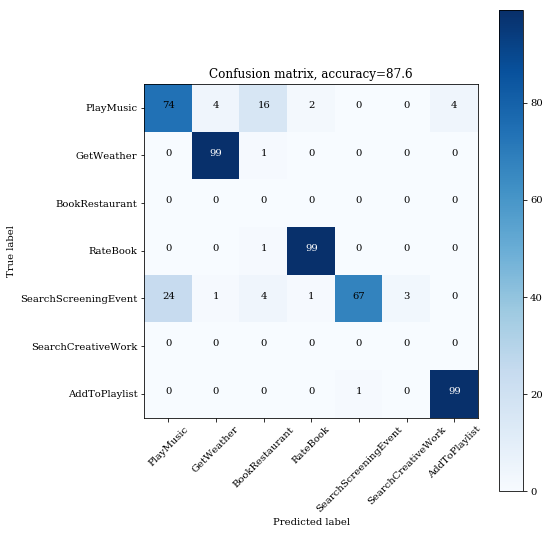

In [2]:
## Evaluate for each epcoh
eval_examples = processor.get_dev_examples(data_dir)
eval_labeled_examples = []
for example in eval_examples:
    if example.label not in label_unknown:
        eval_labeled_examples.append(example)
        
eval_features = convert_examples_to_features(eval_labeled_examples, label_list, max_seq_length, tokenizer)
logger.info("")
logger.info("***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_features))
logger.info("  Batch size = %d", eval_batch_size)
eval_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
eval_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
eval_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
eval_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
eval_data = TensorDataset(eval_input_ids, eval_input_mask, eval_segment_ids, eval_label_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)


global_step = 0
u = 0.95
l = 0.455 
eta = 0

y_pred_last = np.zeros_like(eval_label_ids)
for _ in trange(int(num_train_epochs), desc="Epoch"):
    model.train()

    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_labeled_dataloader, desc="Iteration (labeled)")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        loss = model(input_ids, segment_ids, input_mask, u, l, 'train', label_ids)
        loss.backward()

        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1

        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
    train_labeled_loss = tr_loss / nb_tr_steps
    
    
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_semi_dataloader, desc="Iteration (all train)")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        loss = model(input_ids, segment_ids, input_mask, u, l, 'train', label_ids, True)
        loss.backward()

        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1

        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
    train_loss = tr_loss / nb_tr_steps
    
    
    
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    y_preds = []
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss = model(input_ids, segment_ids, input_mask, u, l, 'train', label_ids)
            logits = model(input_ids, segment_ids, input_mask)

        logits = logits.detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()

        eval_loss += tmp_eval_loss.mean().item()
        y_preds.append(np.argmax(logits, 1))
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    y_pred = np.hstack(y_preds)
    y_eval = eval_label_ids.numpy()

    results = clustering_score(y_eval, y_pred)
    ## Confusion matrix(reorder y_pred for alignment)
    ind, w = hungray_aligment(y_eval, y_pred)
    d_ind = {i[0]: i[1] for i in ind}
    y_pred_ = pd.Series(y_pred).map(d_ind)
    cm = confusion_matrix(y_eval, y_pred_)

    delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
    y_pred_last = np.copy(y_pred)

    results['u'] = u
    results['l'] = l
    loss = tr_loss
    result = {'eval_loss': eval_loss,
              'results': results,
              'global_step': global_step,
              'train_labeled_loss': train_labeled_loss,
              'train_loss': train_loss,
              'delta_label': delta_label}
    print(cm)
    output_eval_file = os.path.join(output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))
    print(f"{_}: loss={train_loss}, (u, l) = ({round(u, 4)},{round(l, 4)})")
    eta += 1.1 * 0.009
    u = 0.95 - eta
    l = 0.455 + eta*0.1
    if u < l:
        break
results_all.update({'CDAC': results})
print(results, label_unknown)

plot_confusion_matrix(cm, label_list, normalize=False, figsize=(8, 8),
                      title='Confusion matrix, accuracy=' + str(results['ACC']))
# Save a trained model and the associated configuration
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
torch.save(model_to_save.state_dict(), output_model_file)
output_config_file = os.path.join(output_dir, CONFIG_NAME)
with open(output_config_file, 'w') as f:
    f.write(model_to_save.config.to_json_string())

In [3]:
test_examples = processor.get_test_examples(data_dir)
test_features = convert_examples_to_features(test_examples, label_list, max_seq_length, tokenizer)
logger.info("")
logger.info("***** Running testuation *****")
logger.info("  Num examples = %d", len(test_examples))
logger.info("  Batch size = %d", eval_batch_size)
test_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
test_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
test_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
test_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
test_data = TensorDataset(test_input_ids, test_input_mask, test_segment_ids, test_label_ids)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=eval_batch_size)

k = num_labels*fraction
y_true = train_label_ids
num_train_epochs = 100
learning_rate = 5e-5

# Initialize cluster centroids U with representation I
embs_train = []
for batch in tqdm(train_dataloader, desc="Extracting representation I"):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch
    
    with torch.no_grad():
        logits, q = model(input_ids, segment_ids, input_mask, mode='finetune')
    logits = logits.detach().cpu().numpy()
    label_ids = label_ids.to('cpu').numpy()
    embs_train.append(logits)
emb_train = np.vstack(embs_train)

from sklearn.cluster import KMeans
km = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
km.fit(emb_train)
y_pred_last = np.copy(km.cluster_centers_)
model.cluster_layer.data = torch.tensor(km.cluster_centers_).to(device)

model.eval()

# Extracting probabilities Q
embs_test = []
qs = []
for batch in tqdm(test_dataloader, desc="Extracting probabilities Q"):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch
    with torch.no_grad():
        logits, q = model(input_ids, segment_ids, input_mask, mode='finetune')
    q = q.detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    qs.append(q)
    embs_test.append(logits)

q_all = np.vstack(qs)
y_pred = q_all.argmax(1)
results = clustering_score(test_label_ids, y_pred)
results_all.update({'CDAC-KM': results})
print(results)

{'ACC': 92.43, 'ARI': 83.4, 'NMI': 86.52}


In [4]:
# Prepare optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
num_train_optimization_steps = int(len(train_examples) / train_batch_size) * num_train_epochs
optimizer = BertAdam(optimizer_grouped_parameters, lr=learning_rate, warmup=warmup_proportion, t_total=num_train_optimization_steps)


import copy
model_best = None
nmi_best = 0
wait, patient = 0, 5
for epoch in range(num_train_epochs):
    # Calculate probabilities P (as target)
    model.eval()
    qs = []
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            logits, q = model(input_ids, segment_ids, input_mask, mode='finetune')
        q = q.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        qs.append(q)
    q_all = np.vstack(qs)
    p_all = target_distribution(q_all)
    y_pred = q_all.argmax(1)
    results = clustering_score(y_true, y_pred)
    
    # early stop
    if results['NMI'] > nmi_best:
        model_best = copy.deepcopy(model)
        wait = 0
        nmi_best = results['NMI']
    else:
        wait += 1
        if wait > patient:
            model = model_best
            break
    
    delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
    y_pred_last = np.copy(y_pred)
    if epoch > 0 and delta_label < 0.001:
        print(epoch, delta_label, 'break')
        break

    # Fine-tuning with auxiliary distribution
    model.train()
    tr_loss, nb_tr_examples, nb_tr_steps = 0, 0, 0
    qs = []
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        logits, q = model(input_ids, segment_ids, input_mask, mode='finetune')
        kl_loss = F.kl_div(q.log(), torch.Tensor(p_all[step*train_batch_size: (step+1)*train_batch_size]).cuda())
        kl_loss.backward()

        tr_loss += kl_loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1

        optimizer.step()
        optimizer.zero_grad()        
    train_loss = tr_loss / nb_tr_steps
    results['kl_loss'] = round(train_loss, 4)
    results['delta_label'] = delta_label.round(4)
    print(epoch, results)


# Extracting probabilities Q
embs_test = []
qs = []
for batch in tqdm(test_dataloader, desc="Extracting probabilities Q"):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch
    with torch.no_grad():
        logits, q = model(input_ids, segment_ids, input_mask, mode='finetune')
    q = q.detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    qs.append(q)
    embs_test.append(logits)

q_all = np.vstack(qs)
y_pred = q_all.argmax(1)
y_true = test_label_ids

results = clustering_score(y_true, y_pred)
results_all.update({'CDAC+': results})
print(results)

/home/tony/anaconda3/envs/BERT/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


0 {'ACC': 93.55, 'ARI': 85.48, 'NMI': 87.3, 'kl_loss': 0.0392, 'delta_label': 0.0001}
1 {'ACC': 95.68, 'ARI': 90.64, 'NMI': 90.91, 'kl_loss': 0.0377, 'delta_label': 0.0313}
2 {'ACC': 96.15, 'ARI': 91.69, 'NMI': 91.76, 'kl_loss': 0.0386, 'delta_label': 0.0099}
3 {'ACC': 96.29, 'ARI': 92.04, 'NMI': 92.12, 'kl_loss': 0.0393, 'delta_label': 0.0062}
4 {'ACC': 96.33, 'ARI': 92.15, 'NMI': 92.3, 'kl_loss': 0.0398, 'delta_label': 0.0035}
5 {'ACC': 96.33, 'ARI': 92.17, 'NMI': 92.39, 'kl_loss': 0.0399, 'delta_label': 0.0034}
6 {'ACC': 96.32, 'ARI': 92.14, 'NMI': 92.38, 'kl_loss': 0.0397, 'delta_label': 0.0033}
7 {'ACC': 96.26, 'ARI': 92.05, 'NMI': 92.35, 'kl_loss': 0.04, 'delta_label': 0.0019}
8 {'ACC': 96.25, 'ARI': 92.02, 'NMI': 92.37, 'kl_loss': 0.0399, 'delta_label': 0.002}
9 {'ACC': 96.19, 'ARI': 91.91, 'NMI': 92.31, 'kl_loss': 0.0398, 'delta_label': 0.0014}
10 {'ACC': 96.16, 'ARI': 91.85, 'NMI': 92.25, 'kl_loss': 0.04, 'delta_label': 0.0016}


{'ACC': 94.0, 'ARI': 87.58, 'NMI': 89.87}
